# Refitting WT binding energies from glucose data 

© 2018 Griffin Chure. This work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained herein is licensed under an [MIT license](https://opensource.org/licenses/MIT).

--- 

In [10]:
import numpy as np
import pandas as pd
import pystan
import mwc.bayes
import mwc.stats
import mwc.viz
import altair as alt
alt.data_transformers.enable('json')


DataTransformerRegistry.enable('json')

I would like to be able to have reliable confidence intervals based on my glucose data. While using the energies determined by Hernan is valid, I would reather determine the binding energy myself since I have reliable repressor counts.  

In [39]:
# Load the compiled data set. 
fc_data = pd.read_csv('../../data/compiled_fold_change.csv')

# Load the fluctutations
fluct_data = pd.read_csv('../../data/compiled_fluctuations.csv') 

# Isolate glucose data. 
gluc_fc = fc_data[(fc_data['carbon']=='glucose') & (fc_data['strain']=='dilution')].copy()
gluc_fluct = fluct_data[(fluct_data['carbon']=='glucose')].copy()

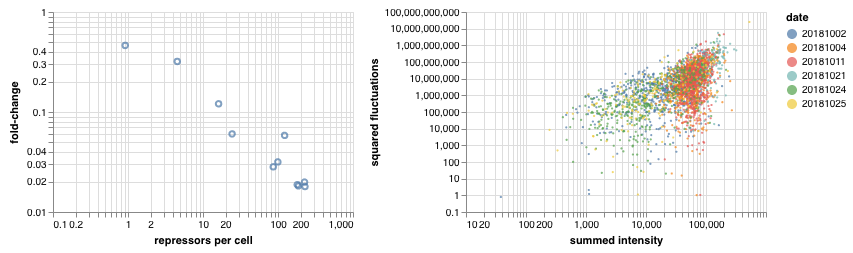

In [32]:
# Plot all glucose data. 
fc_points = alt.Chart(data=gluc_fc[gluc_fc['fold_change'] >= 0],
                     width=300, height=200).mark_point(
    ).encode(
        x=alt.X('mean_rep:Q', scale={'type':'log'}, axis={'title':'repressors per cell'}), 
        y=alt.Y('mean_fc:Q', scale={'type':'log'}, axis={'title':'fold-change'})
    ).transform_aggregate(
        mean_rep='mean(repressors)',
        mean_fc='mean(fold_change)',
        groupby=['atc_ngml'])

# Plot the fluctuation data. 
fluct_points = alt.Chart(data=gluc_fluct[(gluc_fluct['summed'] > 0) &
                                        (gluc_fluct['sq_fluct'] > 0)],
                         width=300, height=200
    ).mark_point(filled=True, size=5
    ).encode(
    x=alt.X('summed:Q', scale={'type':'log'}, axis={'title':'summed intensity'}),
    y=alt.Y('sq_fluct:Q', scale={'type':'log'}, axis={'title':'squared fluctuations'}),
    color='date:N') 

fc_points | fluct_points

The goal here will be to simultaneously infer the calibration factor for each replicate of the glucose data and use that to infer the repressor copy number. The repressor copy number will then be used to infer the DNA binding energy. This becomes a somewhat complicated model, but should be easy to fit.  

In [83]:
# Add identifiers. 
gluc_fc = gluc_fc[gluc_fc['mean_mCherry'] >= 0].copy()
gluc_fc['conc_idx'] = gluc_fc.groupby(['atc_ngml']).ngroup() + 1
gluc_fc['run_idx'] = gluc_fc.groupby(['date', 'run_number']).ngroup() + 1
gluc_fc['conc_run_idx'] = gluc_fc.groupby(['date', 'run_number', 'atc_ngml']).ngroup() + 1
gluc_fluct['run_idx'] = gluc_fluct.groupby(['date', 'run_no']).ngroup() + 1

# Assemble the data dictionary. 
data_dict = {'J_conc':gluc_fc['conc_idx'].max(),
            'J_runs':gluc_fc['run_idx'].max(),
            'J_conc_runs':gluc_fc['conc_run_idx'].max(),
            'N_fluct':len(gluc_fluct),
            'N_fc': len(gluc_fc),
            'fluct_index':gluc_fluct['run_idx'],
             'fc_index_run':gluc_fc['run_idx'],
            'fc_index_conc':[key[0] for key, value in gluc_fc.groupby(['conc_idx', 'conc_run_idx'])],
            'fc_conc_run_idx':gluc_fc['conc_run_idx'],
            'fc_index_replicates':gluc_fc['conc_run_idx'],
            'I_1': gluc_fluct['I_1'],
            'I_2': gluc_fluct['I_2'],
            'mCherry': gluc_fc['mean_mCherry'] *  gluc_fc['area_pix'],
            'fc': gluc_fc['fold_change']}

# Load the stan model. 
model = mwc.bayes.StanModel('../stan/simultaneous_epRA_cal_factor.stan', data_dict=data_dict)

Found precompiled model. Loading...
finished!


In [84]:
model.sample(iter=500)

Beginning sampling...


finished sampling!


[
 For the full summary use 'print(fit)'
 
 Inference for Stan model: anon_model_13f33600b64320dc53b2c03b4016f9ce.
 4 chains, each with iter=500; warmup=250; thin=1; 
 post-warmup draws per chain=250, total post-warmup draws=1000.
 
                      mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
 alpha_mu           780.89    3.94  30.82 715.51 761.64 781.46 800.98 839.93     61   1.06
 alpha_sigma         54.22    0.85   6.52   42.0  49.41  53.76  57.96  69.11     59   1.07
 ep_RA               -11.5    6.36   9.51 -23.91 -16.38 -15.01  -9.34   7.75      2   3.54
 sigma                0.25    0.29   0.42 4.1e-3 9.2e-3   0.02   0.36   1.21      2    4.7
 R_mu[1]             12.89    0.62   5.75   0.74  11.59  12.73  13.89  27.88     86   1.01
 R_mu[2]             35.59    3.89  19.68   0.04  26.24  41.65   48.4  64.56     26   1.08
 R_mu[3]             77.62    5.77  41.72   0.13  47.99  89.65 108.05 137.18     52   1.05
 R_mu[4]             98.98    7.26  37.

In [78]:
gluc_fc['conc_run_idx'].unique()

array([ 4,  5,  3,  2,  1,  9, 11, 10,  8,  7,  6, 15, 17, 16, 14, 13, 12,
       21, 23, 22, 20, 19, 18, 29, 27, 28, 25, 26, 24, 35, 33, 34, 31, 32,
       30])

In [85]:
model.traceplot(varnames=['alpha_mu', 'R_mu', 'ep_RA'])